In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from malbecs.preprocess import meteo

In [92]:
path = '../../data/raw/DATOS_METEO.TXT'
meteo_data = meteo.load_meteo_data(path)

In [93]:
meteo_data.columns

Index(['validTimeUtc', 'precip1Hour', 'precip6Hour', 'precip24Hour',
       'precip2Day', 'precip3Day', 'precip7Day', 'precipMtd', 'precipYtd',
       'pressureChange', 'pressureMeanSeaLevel', 'relativeHumidity',
       'snow1Hour', 'snow6Hour', 'snow24Hour', 'snow2Day', 'snow3Day',
       'snow7Day', 'snowMtd', 'snowSeason', 'snowYtd', 'temperature',
       'temperatureChange24Hour', 'temperatureMax24Hour',
       'temperatureMin24Hour', 'temperatureDewPoint', 'temperatureFeelsLike',
       'uvIndex', 'visibility', 'windDirection', 'windGust', 'windSpeed',
       'ID_ESTACION'],
      dtype='object')

# Variables a Calcular:

1.  

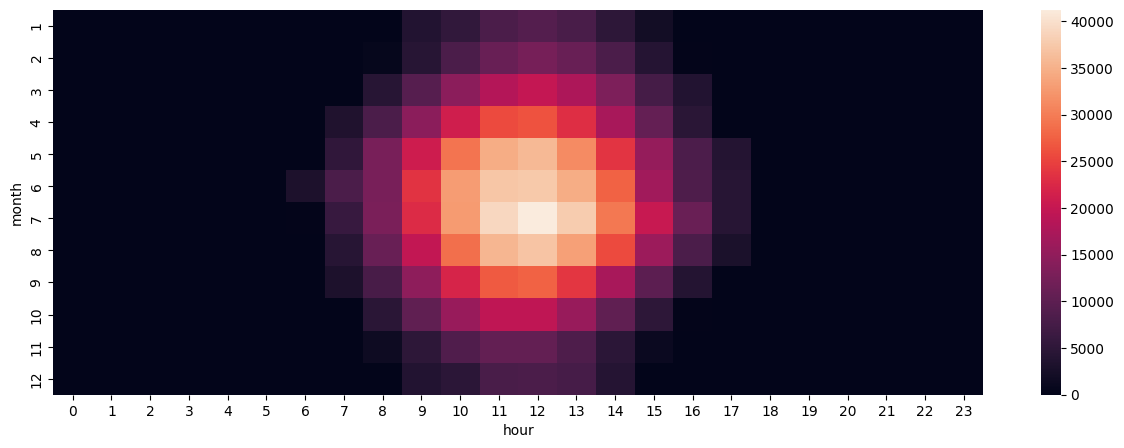

In [94]:
# meteo_data['uvIndex'].hist()
plt.figure(figsize=(15, 5))

sns.heatmap(
(
    meteo_data
    .groupby([
        meteo_data.validTimeUtc.dt.hour,
        meteo_data.validTimeUtc.dt.month,
    ]).agg({
        "uvIndex": "sum"
    })
    .unstack(1)
    .droplevel(0, 1)
    .T
)
)
plt.xlabel("hour")
plt.ylabel('month')
plt.show()

In [95]:
meteo_data['LightHours'] = meteo_data['uvIndex']>0

light_hours = meteo_data.groupby([
    'ID_ESTACION', 
    pd.to_datetime(meteo_data.validTimeUtc.dt.date)]
    )['LightHours'].sum().reset_index()


light_hours = light_hours.groupby([
    'ID_ESTACION',
    light_hours.validTimeUtc.dt.year,
    light_hours.validTimeUtc.dt.month
]).agg(
    SumLightHours=('LightHours','sum'),
    MeanLightHours=('LightHours', 'mean')
)

light_hours.index.names = ['ID_ESTACION', 'year', 'month']

light_hours = light_hours.reset_index()

months = [1, 2, 3, 4, 5, 6]
light_hours = light_hours[light_hours['month'].isin(months)]

light_hours_pivot = light_hours.pivot(
    index=['ID_ESTACION', "year"],
    columns=['month'],
    values=['SumLightHours', 'MeanLightHours']
).reset_index()

light_hours_pivot = meteo.flatten_pivot_columns(light_hours_pivot)

light_hours_pivot = meteo.fillna_by_group(
    light_hours_pivot,
    cols=light_hours_pivot.columns,
    group=['ID_ESTACION']
)


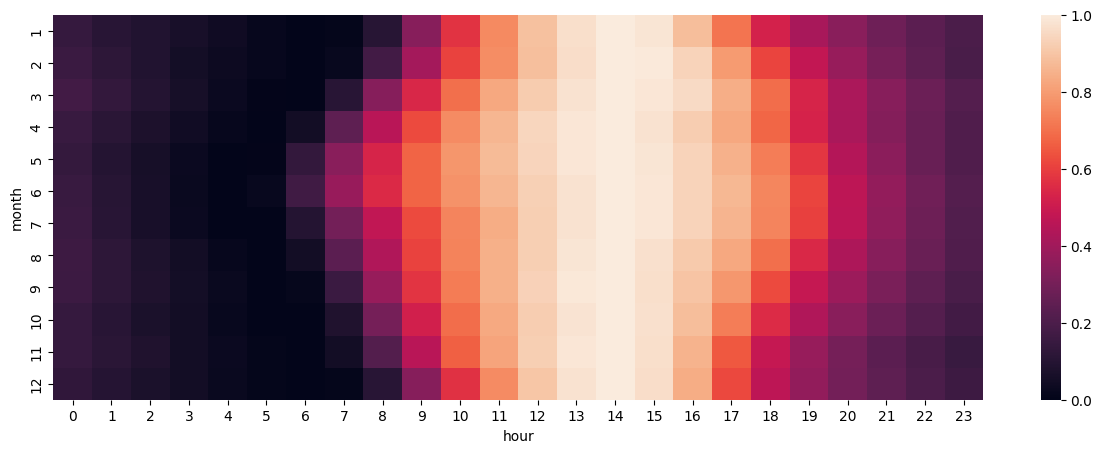

In [96]:
plt.figure(figsize=(15,5))

sns.heatmap(

(
    meteo_data
    .groupby([
    meteo_data.validTimeUtc.dt.hour,
    meteo_data.validTimeUtc.dt.month,
    ]).agg({
        "temperature":"mean"
    })
    .unstack(1)
    .droplevel(0,1)
    .pipe(lambda df: (df-df.min(axis=0))/(df.max(axis=0) - df.min(axis=0)))
    .T
)
)
plt.xlabel("hour")
plt.ylabel('month')
plt.show()

In [97]:
daytime_temp = meteo.get_daily_mean_by_hour_range(meteo_data, 'temperature', 12, 16)
nighttime_temp = meteo.get_daily_mean_by_hour_range(meteo_data, 'temperature', 1, 5)


In [98]:
temp_features = daytime_temp.merge(
    nighttime_temp, 
    left_on=['ID_ESTACION','date'], 
    right_on=['ID_ESTACION','date']
)
temp_features.columns

Index(['ID_ESTACION', 'date', 'temperature_avg_from_12_to_16',
       'temperature_avg_from_1_to_5'],
      dtype='object')

In [99]:
montly_temp_features = temp_features.groupby([
    'ID_ESTACION',
    temp_features.date.dt.year,
    temp_features.date.dt.month
]).agg({
    "temperature_avg_from_12_to_16":"max",
    "temperature_avg_from_1_to_5":"min"
}).rename(columns={
    "temperature_avg_from_12_to_16":"max_12_to_16_temp",
    "temperature_avg_from_1_to_5":"min_1_to_5_temp"
})


In [100]:
# .unstack(0).plot().legend(bbox_to_anchor=(1, 1))
# montly_temp_features


In [101]:
# montly_temp_features

In [102]:
montly_temp_features.index.names = ['ID_ESTACION', 'year', 'month']

In [103]:
montly_temp_features = montly_temp_features.reset_index()

In [104]:
months=[1,2,3,4,5,6]
montly_temp_features = montly_temp_features[montly_temp_features['month'].isin(months)]

In [105]:
montly_temp_pivot = montly_temp_features.pivot(
    index=['ID_ESTACION',"year"],
    columns=['month'],
    values=['max_12_to_16_temp','min_1_to_5_temp']
).reset_index()

In [106]:
montly_temp_pivot = meteo.flatten_pivot_columns(montly_temp_pivot)

In [107]:
montly_temp_pivot = meteo.fillna_by_group(
    montly_temp_pivot,
    cols=montly_temp_pivot.columns,
    group=['ID_ESTACION']
)

In [110]:
montly_temp_pivot.head()

,ID_ESTACION,year,max_12_to_16_temp_month_1,max_12_to_16_temp_month_2,max_12_to_16_temp_month_3,max_12_to_16_temp_month_4,max_12_to_16_temp_month_5,max_12_to_16_temp_month_6,min_1_to_5_temp_month_1,min_1_to_5_temp_month_2,min_1_to_5_temp_month_3,min_1_to_5_temp_month_4,min_1_to_5_temp_month_5,min_1_to_5_temp_month_6
0,0,2015,19.345714,20.417143,23.471429,24.247857,29.128571,35.02,-0.588571,2.068571,2.734286,4.422857,8.262857,18.04
1,0,2016,19.620000,20.460000,23.840000,23.875000,28.800000,34.10,0.020000,-0.020000,2.260000,4.800000,4.880000,12.44
2,0,2017,16.460000,16.940000,27.460000,26.140000,29.420000,34.54,-3.460000,1.300000,3.160000,5.160000,8.500000,12.06
3,0,2018,20.980000,18.460000,23.320000,22.800000,25.680000,31.84,1.760000,-0.380000,-0.300000,5.360000,6.260000,11.90
4,0,2019,17.020000,21.820000,23.980000,24.840000,27.380000,36.14,-2.100000,1.540000,2.540000,5.800000,6.880000,9.72


In [114]:
meteo_pro = montly_temp_pivot.merge(
    light_hours_pivot,
    left_on=['ID_ESTACION','year'],
    right_on=['ID_ESTACION', 'year']
)

In [115]:
meteo_pro.to_csv('../../data/processed/meteo_pro.csv', index=False)
